In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

```markdown
## Incremental Fitting and Boosting

### Incremental Fitting

In the relevance vector classification model, we applied a prior that encourages sparsity in the dual logistic regression parameters $ \psi $, resulting in dependency on only a subset of the training data. Similarly, we can develop a sparse logistic regression method by placing a prior that encourages sparsity in the original parameters $ \phi $, thereby relying on only a subset of the data dimensions.

### Logistic Regression Model
The probability of the class given the data is expressed as:
$$
P(w_i | x_i) = \text{Bern}_{w_i} [\sigma(a_i)]
$$
where $ \sigma(\cdot) $ is the logistic sigmoid function, and the activation $ a_i $ is:
$$
a_i = \phi^T z_i = \phi^T f(x_i)
$$
where $ f(\cdot) $ is a nonlinear transformation. Expressing the activation term explicitly as a weighted sum:
$$
a_i = \phi_0 + \sum_{k=1}^{K} \phi_k f(x_i, \xi_k)
$$
where $ f(\cdot, \cdot) $ is a fixed nonlinear function. Common choices for $ f(\cdot, \cdot) $ include radial basis functions:
$$
f(x, \xi) = \exp\left(- \frac{(x - \alpha)^T (x - \alpha)}{\lambda_0^2} \right)
$$
and arc tangent functions:
$$
f(x, \xi) = \arctan(\alpha^T x)
$$

### Incremental Learning Procedure
The activation is built incrementally:
1. Start with:
$$
a_i = \phi_0 + \phi_1 f(x_i, \xi_1)
$$
and learn parameters $ \phi_0, \phi_1, \xi_1 $.
2. At step $ K $:
$$
a_i = \phi_0 + \sum_{k=1}^{K} \phi_k f(x_i, \xi_k)
$$
and learn $ \phi_0, \phi_K, \xi_K $, keeping previous parameters fixed.
3. Use maximum likelihood estimation and a nonlinear optimization method to optimize the log-posterior probability.

This approach creates sparse models by focusing on the most influential features early, handles high-dimensional data efficiently, and reduces computational complexity.

## Boosting
Boosting extends incremental fitting by combining multiple weak classifiers to create a strong classifier.

### LogitBoost Model
Using step functions as weak classifiers:
$$
a_i = \phi_0 + \sum_{k=1}^{K} \phi_k H(\alpha_k^T x_i)
$$
where $ H(\cdot) $ is the Heaviside step function. Instead of optimizing continuously, we select $ \alpha_k $ from a predefined set and optimize $ \phi_k $ using nonlinear optimization.

### Procedure
1. Predefine a set of $ J $ weak classifiers.
2. Select the best $ \alpha_k $ by evaluating log-likelihood improvement.
3. Optimize $ \phi_0 $ and $ \phi_k $ using one Newton step.
4. Repeat until convergence.

Fig.16 illustrates boosting with step functions, showing how decision boundaries evolve with added functions.


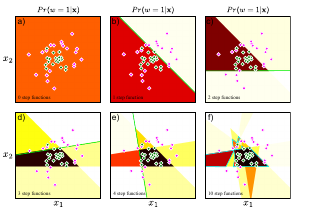

Fig.16 Boosting. a) We start with a uniform prediction P r(w = 1|x) and b) incrementally add a step function to the activation (green line indi- cates position of step). In this case the parameters of the step function were chosen greedily from a pre-determined set containing 20 angles each with 40 oﬀsets. c)-e) As subsequent functions are added the overall classiﬁcation improves. f) However, the ﬁnal decision surface (cyan line) is complex and does not interpolate smoothly between regions of high conﬁdence.

Boosting Model Accuracy: 0.96


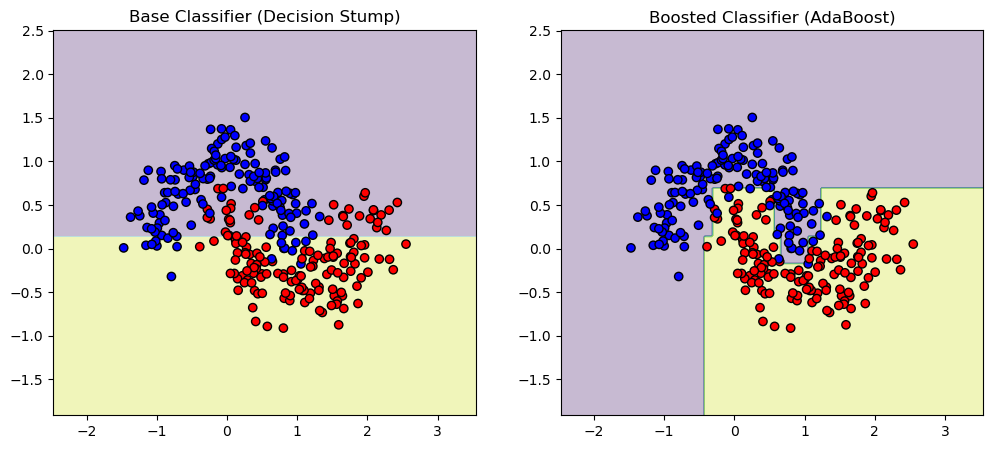

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize base classifier (Decision Stump)
base_clf = DecisionTreeClassifier(max_depth=1)

# Train AdaBoost with decision stumps
boosting_clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=10, learning_rate=1.0, random_state=42)
boosting_clf.fit(X_train, y_train)

# Predictions and accuracy
y_pred = boosting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Boosting Model Accuracy: {accuracy:.2f}")

# Plot decision boundary
def plot_decision_boundary(clf, X, y, ax):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.bwr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title("Base Classifier (Decision Stump)")
plot_decision_boundary(base_clf.fit(X_train, y_train), X, y, axes[0])

axes[1].set_title("Boosted Classifier (AdaBoost)")
plot_decision_boundary(boosting_clf, X, y, axes[1])

plt.show()


## Branching Logistic Regression and Classification Trees

### Introduction

In this notebook, we explore the **Branching Logistic Regression** model, which partitions data space and applies different classifiers in different regions. We also extend this idea to **Classification Trees**, which use hierarchical gating functions to achieve complex decision boundaries.

## Branching Logistic Regression

A branching logistic regression model introduces a **gating function** $ g[x_i, \omega] $, which determines how different linear classifiers contribute to the final decision.

### Activation Function
The activation function is defined as:

$$ a_i = (1 - g[x_i , \omega]) \phi^T_0 x_i + g[x_i , \omega] \phi^T_1 x_i $$

where:
- $ \phi_0 x_i $ and $ \phi_1 x_i $ are linear experts specializing in different data regions.
- $ g[x_i, \omega] $ is a logistic sigmoid gating function:

$$ g[x_i, \omega] = \text{sig}(\omega^T x_i) $$

- If $ g[x_i, \omega] $ is **0**, the activation follows $ \phi_0 x_i $.
- If $ g[x_i, \omega] $ is **1**, the activation follows $ \phi_1 x_i $.
- Otherwise, the activation is a weighted sum.
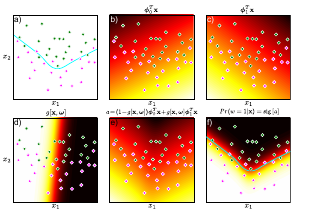

Fig.17 Branching logistic regression. a) This data set needs a nonlinear decision surface (cyan line) to classify the data reasonably. b) This linear activation is an expert that is specialized to describing the right-hand side of the data. c) This linear activation is an expert that describes the left- hand side of the data. d) A gating function takes the data vector x and returns a number between 0 and 1, which we will use to decide which expert contributes at each decision. e) The ﬁnal activation consists of a weighted sum of the activation indicated by the two experts where the weight comes from the gating function. f) The ﬁnal classiﬁer predictions P r(w = 1|x) are generated by passing this activation through the logistic sigmoid function.

### Training
The parameters $ \theta = \{\phi_0, \phi_1, \omega\} $ are learned by maximizing the **log-likelihood**:

$$ L = \sum_i \log P(w_i | x_i) $$

where $ P(w_i | x_i) $ is the probability of the class given the activation function. 

---

## Classification Trees

We extend branching logistic regression into a hierarchical structure known as a **Classification Tree**. The activation function for a simple tree is:

$$
\begin{aligned}
    a_i = & (1 - g[x_i , \omega]) \Big( \phi^T_0 x_i + (1 - g[x_i , \omega^0]) \phi^T_{00} x_i + g[x_i , \omega^0] \phi^T_{01} x_i \Big) \\
    & + g[x_i , \omega] \Big( \phi^T_1 x_i + (1 - g[x_i , \omega^1]) \phi^T_{10} x_i + g[x_i , \omega^1] \phi^T_{11} x_i \Big)
\end{aligned}
$$

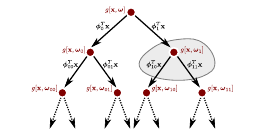

Fig.18 Logistic classiﬁcation tree. Data ﬂows from the root to the leaves. Each node is a gating function that weights the contributions of terms in the sub-branches in the ﬁnal activation. The gray region indi- cates variables that would be learned together in an incremental training approach.


### Learning in Classification Trees
Training is performed in an **incremental fashion**:
1. Fit the **top branch** (parameters $ \omega, \phi_0, \phi_1 $).
2. Fit the **left sub-branch** (parameters $ \omega^0, \phi_{00}, \phi_{01} $).
3. Fit the **right sub-branch** (parameters $ \omega^1, \phi_{10}, \phi_{11} $).
4. Recursively extend as necessary.

### Advantages of Classification Trees
- **Efficiency**: If gating functions produce binary outputs, each data point follows a single path to a **leaf node**.
- **Specialization**: Each data point receives specialized processing based on the region it falls into.
- **Shallow trees**: Typically, trees do not need to be deep, leading to fast classification.

---

## Conclusion
Branching logistic regression and classification trees provide powerful tools for creating complex decision boundaries. The gating function allows different linear classifiers to specialize in different regions, leading to improved performance in classification tasks.


Test Accuracy: 0.88


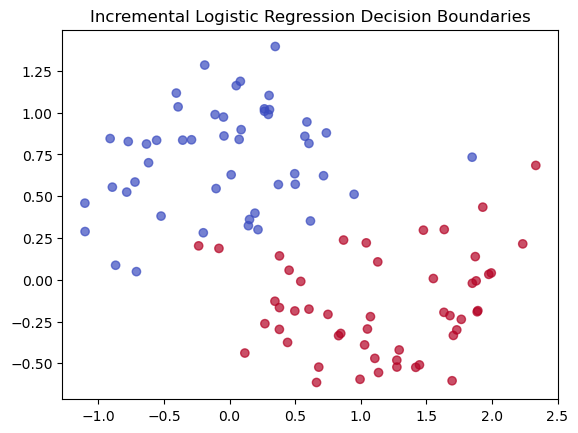

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

class IncrementalLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, num_features=10, learning_rate=0.1, max_iter=100):
        self.num_features = num_features
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.phi = []
        self.xi = []
        self.bias = 0
    
    def _rbf(self, x, center, scale):
        return np.exp(-np.linalg.norm(x - center, axis=1) ** 2 / (2 * scale ** 2))
    
    def fit(self, X, y):
        np.random.seed(42)
        centers = np.random.randn(self.num_features, X.shape[1])
        scales = np.random.rand(self.num_features) * 2 + 0.5
        
        self.phi = np.zeros(self.num_features)
        self.xi = [(centers[i], scales[i]) for i in range(self.num_features)]
        
        for k in range(self.num_features):
            phi_k = np.random.randn()
            for _ in range(self.max_iter):
                f_x = self.bias + sum(self.phi[j] * self._rbf(X, *self.xi[j]) for j in range(k + 1))
                preds = sigmoid(f_x)
                error = preds - y
                gradient = np.dot(error, self._rbf(X, *self.xi[k]))
                phi_k -= self.learning_rate * gradient.mean()
            self.phi[k] = phi_k
        
        return self
    
    def predict_proba(self, X):
        f_x = self.bias + sum(self.phi[k] * self._rbf(X, *self.xi[k]) for k in range(self.num_features))
        return sigmoid(f_x)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

# Generate synthetic dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Incremental Logistic Regression model
model = IncrementalLogisticRegression(num_features=10, learning_rate=0.1, max_iter=100)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Visualization
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', alpha=0.7)
plt.title("Incremental Logistic Regression Decision Boundaries")
plt.show()
